In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes

In [24]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 80

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [25]:
lp.update_hyperparameters( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [26]:
lp.create_loaders()

In [27]:
class ForwardScatteringConvolutional(nn.Module):
    def __init__(self, N_blocks) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.sequence_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
            #nn.BatchNorm1d(512)
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU(),
            #nn.BatchNorm1d(128)
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            x =  self.sequence_block(x)
        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)
model_simple_conv = ForwardScatteringConvolutional(N_blocks)

In [28]:
lp.set_model(model_simple_conv)
lp.set_optimizer()

In [29]:
lp.train()

Epoch 0: training loss: 1182.9611756859756, test loss: 1115.5383513077445
Epoch 1: training loss: 1129.0703043123572, test loss: 1109.7115903108017
Epoch 2: training loss: 1129.5489516839748, test loss: 1111.0417400857677
Epoch 3: training loss: 1128.4316465796494, test loss: 1111.6553158967392
Epoch 4: training loss: 1128.436943240282, test loss: 1114.538669752038
Epoch 5: training loss: 1127.3423640553544, test loss: 1106.6451575237772
Epoch 6: training loss: 1124.0423241592034, test loss: 1106.2202360733695
Epoch 7: training loss: 1126.6543460008575, test loss: 1109.4335964037025
Epoch 8: training loss: 1125.474994938548, test loss: 1120.7010020380435
Epoch 9: training loss: 1126.2437491068026, test loss: 1142.291700280231
Epoch 10: training loss: 1128.8338369974276, test loss: 1107.9777327827785
Epoch 11: training loss: 1125.4529031893103, test loss: 1138.5593155570652
Epoch 12: training loss: 1125.883168290301, test loss: 1115.0421673318615
Epoch 13: training loss: 1127.8049033560

In [30]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

Accuracy is 31.56%
MSE for radius per shape for correctly identified instances as follows: sphere: 48528.7695, hardsphere: inf and cylinder: 31527.8672
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 52527.7070, hardsphere: inf and cylinder: 5942.4204
MSE for cylinder length for correctly identified instances: 12341.7725
MSE for cylinder length polydispersity for correctly identified instances: 121715.1562
MSE for cylinder length for correctly identified instances: inf


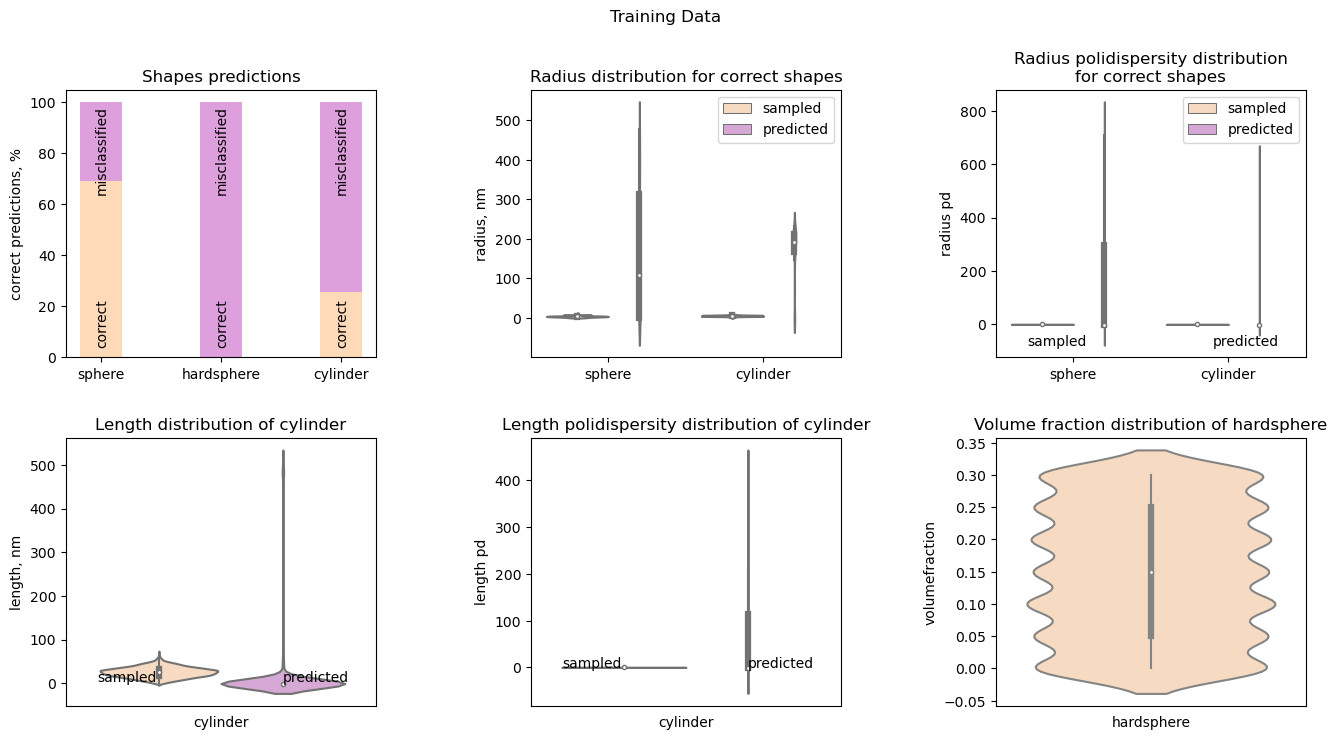

In [31]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 32.37%
MSE for radius per shape for correctly identified instances as follows: sphere: 50040.0469, hardsphere: inf and cylinder: 32975.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 49446.8477, hardsphere: inf and cylinder: 7028.0039
MSE for cylinder length for correctly identified instances: 10706.5283
MSE for cylinder length polydispersity for correctly identified instances: 127791.5312
MSE for cylinder length for correctly identified instances: inf


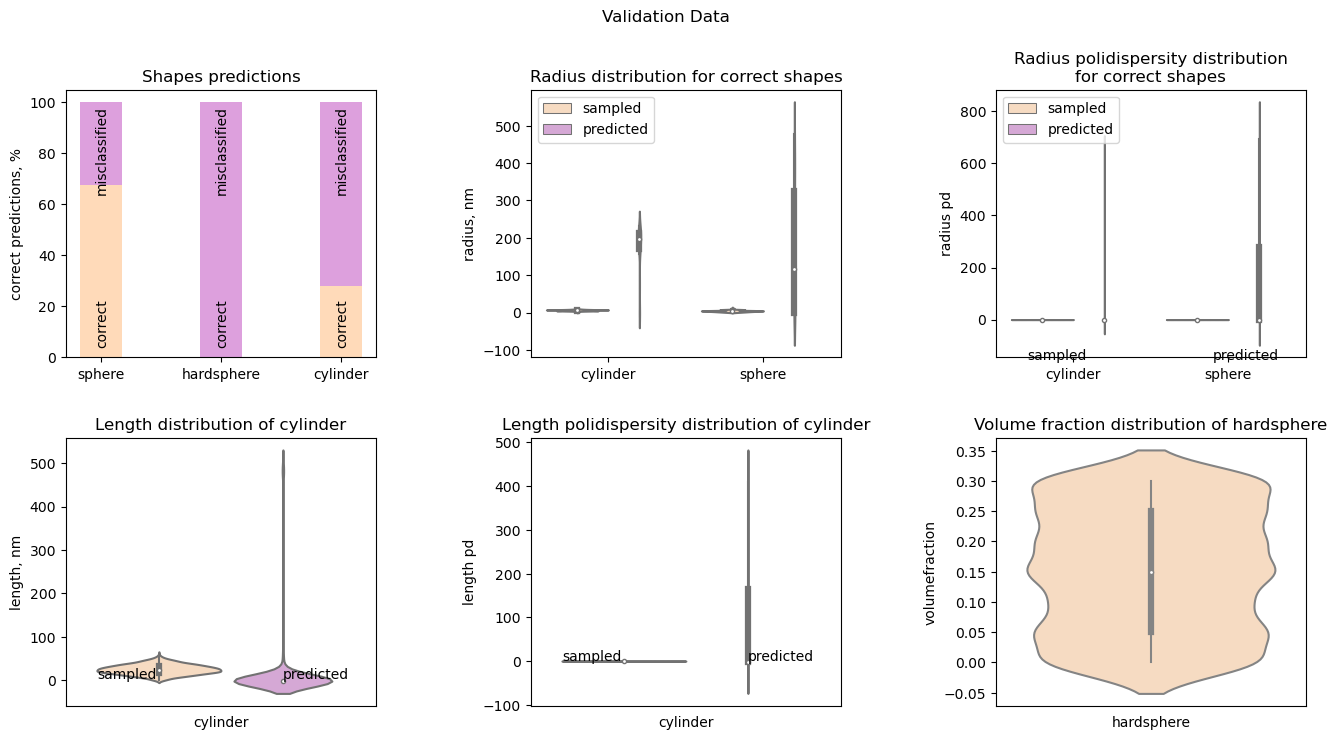

In [32]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 33.07%
MSE for radius per shape for correctly identified instances as follows: sphere: 54099.6172, hardsphere: inf and cylinder: 32597.1191
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 42223.8438, hardsphere: inf and cylinder: 4329.3110
MSE for cylinder length for correctly identified instances: 11025.0771
MSE for cylinder length polydispersity for correctly identified instances: 126727.3047
MSE for cylinder length for correctly identified instances: inf


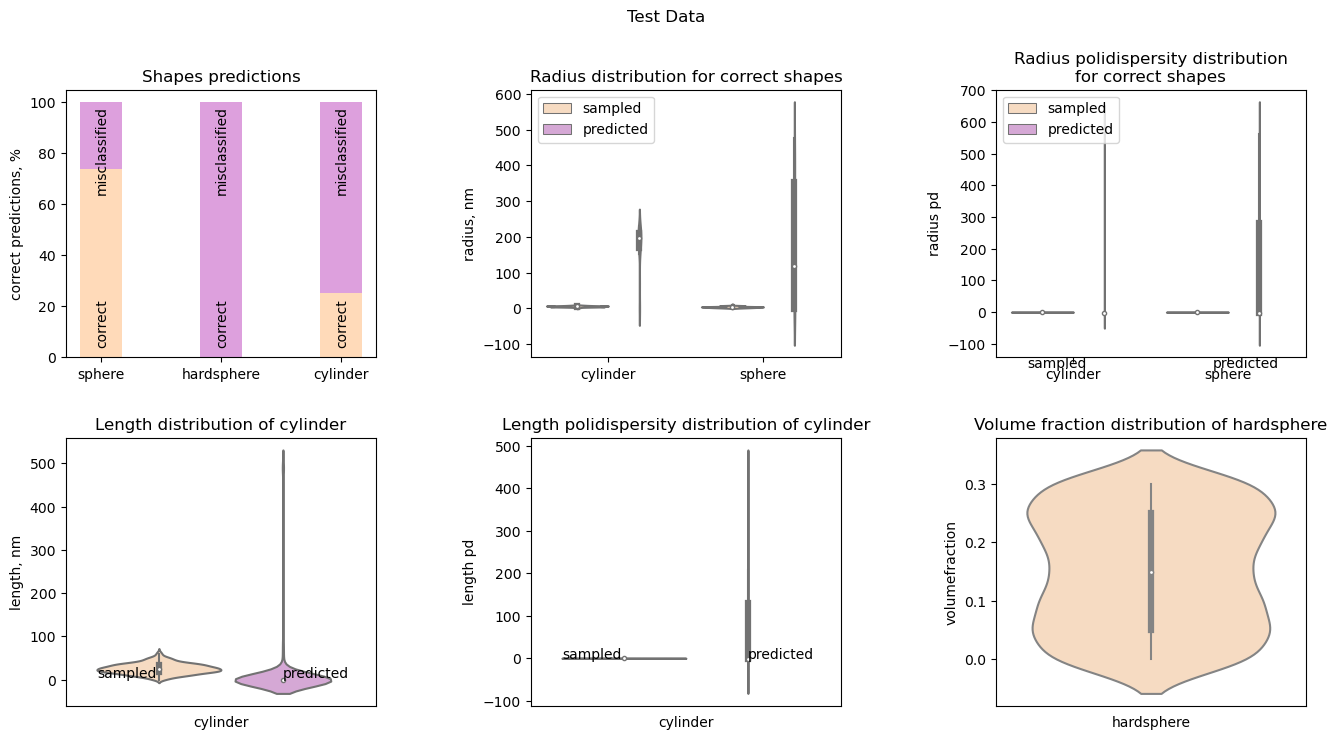

In [33]:
plot_outcomes_identified(df_test, 'Test')